##### Graph generation for single image (unlabelled edges)

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import csv
from numpy import genfromtxt
from scipy.spatial import distance
import os
import glob
from pylab import *
from matplotlib.pyplot import imread
import networkx as nx

Plot sample frame (tonemap + semantic segmentation)

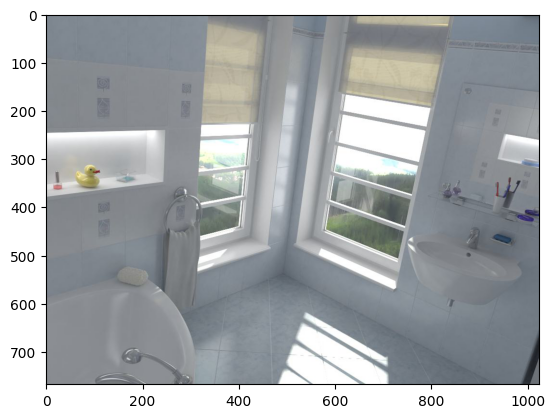

In [2]:
frame_no = 1

# import sample tonemap
sample_tonemap_image = imread(r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\images\scene_cam_00_final_preview\frame.0001.tonemap.jpg")

# import semantic segmentation of sample image
semantic_inst_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\images\scene_cam_00_geometry_hdf5\frame.0001.semantic_instance.hdf5"
with h5py.File(semantic_inst_path, "r") as f: semantic_inst = f['dataset'][:]

plt.imshow(sample_tonemap_image)
# plt.imshow(semantic_inst)

Import data for all 99 frames

In [3]:
# import camera positions + orientations files
camera_positions_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\cam_00\camera_keyframe_positions.hdf5"
camera_orientations_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\cam_00\camera_keyframe_orientations.hdf5"

# import bb information
bb_size_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\mesh\metadata_semantic_instance_bounding_box_object_aligned_2d_extents.hdf5"
bb_orientation_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\mesh\metadata_semantic_instance_bounding_box_object_aligned_2d_orientations.hdf5"
bb_position_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\mesh\metadata_semantic_instance_bounding_box_object_aligned_2d_positions.hdf5"
# bb_names = ...

# import bb label information (will be grouped under bb_names)
mesh_objects_si_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\evermotion_dataset\scenes\ai_001_001\_detail\mesh\mesh_objects_si.hdf5"
mesh_objects_sii_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\evermotion_dataset\scenes\ai_001_001\_detail\mesh\mesh_objects_sii.hdf5"
metadata_objects_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\evermotion_dataset\scenes\ai_001_001\_detail\mesh\metadata_objects.csv"
nyu_labels_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\code\cpp\tools\scene_annotation_tool\semantic_label_descs.csv"

with h5py.File(camera_positions_path, "r") as f: camera_positions = f['dataset'][:]
with h5py.File(camera_orientations_path, "r") as f: camera_orientations = f['dataset'][:]

with h5py.File(bb_size_path, "r") as f: bb_sizes = f['dataset'][:]
with h5py.File(bb_orientation_path, "r") as f: bb_orientations = f['dataset'][:]
with h5py.File(bb_position_path, "r") as f: bb_positions = f['dataset'][:]

with h5py.File(mesh_objects_si_path, "r") as f: mesh_objects_si = f['dataset'][:]
with h5py.File(mesh_objects_sii_path, "r") as f: mesh_objects_sii = f['dataset'][:]
metadata_objects = genfromtxt(metadata_objects_path, delimiter=None, dtype=str)
nyu_labels = genfromtxt(nyu_labels_path, delimiter=',', dtype=None, encoding=None, autostrip=True)

In [4]:
# import asset to meters unit conversion
with open(r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\metadata_scene.csv", newline='') as csvfile:
    metadata_scene = list(csv.reader(csvfile))
    a2m = float(metadata_scene[1][1])

Extract data for the first frame only

In [5]:
sample_camera_orientation = camera_orientations[frame_no]
sample_camera_position = camera_positions[frame_no]

R_world_from_cam = matrix(sample_camera_orientation)
t_world_from_cam = matrix(sample_camera_position).T
R_cam_from_world = R_world_from_cam.T
t_cam_from_world = -R_cam_from_world*t_world_from_cam

height_pixels = sample_tonemap_image.shape[0] 
width_pixels  = sample_tonemap_image.shape[1]

fov_x = pi/3.0
fov_y = 2.0 * arctan(height_pixels * tan(fov_x/2.0) / width_pixels)
near = 1.0
far = 1000.0

f_h    = tan(fov_y/2.0)*near # focal length in h??
f_w    = f_h*width_pixels/height_pixels
left   = -f_w
right  = f_w
bottom = -f_h
top    = f_h

Construct world to screen projection matrix

In [6]:
# Construct M (projection matrix mapping from camera view to clip view)
M_proj      = matrix(zeros((4,4)))
M_proj[0,0] = (2.0*near)/(right - left)
M_proj[1,1] = (2.0*near)/(top - bottom)
M_proj[0,2] = (right + left)/(right - left)
M_proj[1,2] = (top + bottom)/(top - bottom)
M_proj[2,2] = -(far + near)/(far - near)
M_proj[3,2] = -1.0
M_proj[2,3] = -(2.0*far*near)/(far - near)

# Construct world to screen matrix
def transform_point_screen_from_world(p_world):
    # projection matrix for: from P_world to P_cam
    p_cam      = t_cam_from_world + R_cam_from_world*p_world
    p_cam_     = matrix(r_[ p_cam.A1, 1 ]).T
    p_clip     = M_proj*p_cam_
    # projection matrix for: from P_world to P_ndc
    p_ndc      = p_clip/p_clip[3]
    p_ndc_     = p_ndc.A1
    p_screen_x = 0.5*(p_ndc_[0]+1)*(width_pixels-1)
    p_screen_y = (1 - 0.5*(p_ndc_[1]+1))*(height_pixels-1)
    p_screen_z = (p_ndc_[2]+1)/2.0 # why is there a z-component in screen coords?
    p_screen   = matrix([p_screen_x, p_screen_y, p_screen_z]).T
    return p_screen

Assign label to each BB. This is valid for all frames of this scene.

In [7]:
metadata_objects

array(['object_name', 'toilet_bowl', 'ceiling', ..., 'nail_polish_obj_01',
       'nail_polish_obj_02', 'nail_polish_obj_03'], dtype='<U21')

In [8]:
bb_labels = []
n_bb = bb_positions.shape[0] - 1 # 1st element of bb_positions is inf
id_i = np.zeros(n_bb)

for i in range(n_bb):
    instances = np.where(mesh_objects_sii == i+1)[0] # low-level objects belonging to BB i+1
    id_i[i] = mesh_objects_si[instances[0]] # all low-level objects belonging to same BB should have the same label, so just take the 1st one
    if id_i[i] == 40 or id_i[i] == 39 or id_i[i] == 38:
        bb_labels.append(metadata_objects[instances[-1]]) # assign low-level object name to the bounding box when there is no NYU label available
        # print(np.where(mesh_objects_sii == i+1)[0])
        # print(f"-> possible choices: {metadata_objects[instances]}, assigned low-lvl name {metadata_objects[instances[-1]]}")
    else:
        bb_labels.append(nyu_labels[int(id_i[i])][1]) # assign (more general) NYU label rather than low-level object label
        print(f"-> assigned {nyu_labels[int(id_i[i])][1]} instead of {metadata_objects[instances[0]]}")

print(f"Number of BBs: {len(bb_labels)} \n")
print(f"BB labels: {bb_labels}") # labels for each BB

-> assigned towel instead of towel1_obj_01
-> assigned blinds instead of roller2_blind_obj_01
-> assigned window instead of window1_obj_12
-> assigned blinds instead of roller1_blind_obj_01
-> assigned window instead of heater_obj_23
-> assigned lamp instead of lamp_obj_10
-> assigned shelves instead of perfume3_obj_03
-> assigned mirror instead of duck_obj_03
-> assigned sink instead of mirror_obj_05
-> assigned cabinet instead of shelf_01
-> assigned towel instead of floor
-> assigned towel instead of sponge_02
-> assigned toilet instead of object_name
-> assigned lamp instead of roller2_blind_obj_335
-> assigned door instead of cotton_bud_obj_71
-> assigned towel instead of towel_03
-> assigned towel instead of knob
-> assigned lamp instead of lamp_obj_07
-> assigned towel instead of towel1_obj_02
-> assigned bathtub instead of background
-> assigned lamp instead of lamp_obj_01
Number of BBs: 55 

BB labels: ['small_shelf_obj_', 'shampoo2_obj_03', 'nail_polish_obj_02', 'window2_obj_

Filter which BB are present in the sample image (mask)

In [9]:
bb_in_sample = unique(semantic_inst)
if bb_in_sample[0] == -1:
    bb_in_sample = bb_in_sample[1:]

n_bb_in_sample = bb_in_sample.shape[0]

# bb_in_sample_mask = np.zeros((n_bb, n_bb), dtype=int)
# for bb_id in bb_in_sample:
#     bb_in_sample_mask[bb_id, bb_id] = 1

Create distance mask

In [17]:
distance_threshold = 1

bb_position_m = bb_positions*a2m
bb_position_m = np.delete(bb_position_m, 0, axis=0)
# print(bb_position_m.shape)

n_bb = bb_position_m.shape[0]
bb_distances = np.zeros((n_bb, n_bb))

# distance.euclidean(bb_position_m[0,:], bb_position_m[1,:])

for i in range(n_bb):
    for j in range(n_bb):
        bb_distances[i, j] = distance.euclidean(bb_position_m[i, :], bb_position_m[j, :])

distance_mask = bb_distances < distance_threshold # True for objects that are within [threshold] m of other objects
np.fill_diagonal(distance_mask, 0)
np.sum(distance_mask)

540

Project BB centres (positions) from world -> 2D screen for this frame only

In [11]:
bb_pos = {}
for i in bb_in_sample:
    bb_position_ = expand_dims(bb_positions[i], 1)
    bb_position_screen = transform_point_screen_from_world(bb_position_)
    x = np.ravel(bb_position_screen[0])
    x = x.astype(int)
    x = x.item()
    y = np.ravel(bb_position_screen[1])
    y = y.astype(int)
    y = y.item()
    y = - y + height_pixels
    x = np.clip(x, 0, width_pixels) #clip to edge
    y = np.clip(y, 0, height_pixels) #clip to edge
    # y = - y - height_pixels
    bb_pos[i] = (x, y)
# bb_pos

Graph nodes for this frame

In [12]:
bb_not_in_sample = []
j=0
for i in range(n_bb):
    # print(i)
    if i != bb_in_sample[j]:
        bb_not_in_sample.append(i)
    else:
        j += 1

adjacency_matrix = distance_mask
adjacency_matrix[bb_not_in_sample,:] = np.zeros((len(bb_not_in_sample), n_bb))
adjacency_matrix[:, bb_not_in_sample] = np.zeros((n_bb, len(bb_not_in_sample)))

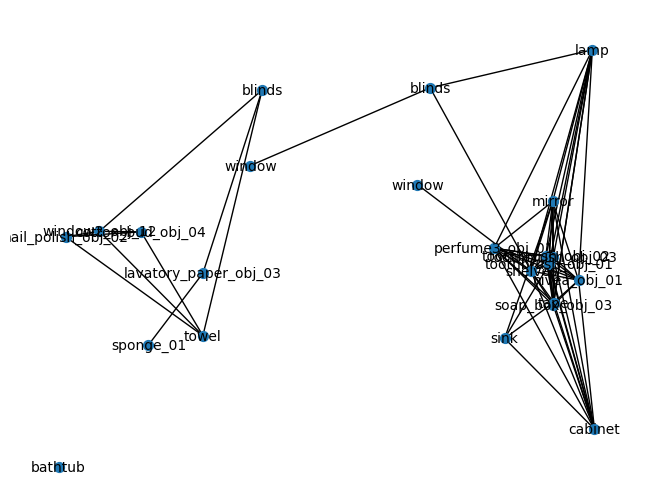

In [13]:
# import hvplot.networkx as hvnx
# import holoviews as hv

node_labels_dict = {}
for i in bb_in_sample:
    node_labels_dict[i] = bb_labels[i-1]
bb_in_sample

rows, cols = np.where(adjacency_matrix == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()

gr.add_nodes_from(bb_in_sample)
gr.add_edges_from(edges)

# plt.imshow(sample_tonemap_image)
nx.draw(gr, pos=bb_pos, node_size=50, with_labels=True, labels=node_labels_dict, font_size=10)
len(gr.nodes), len(bb_in_sample)
plt.show()

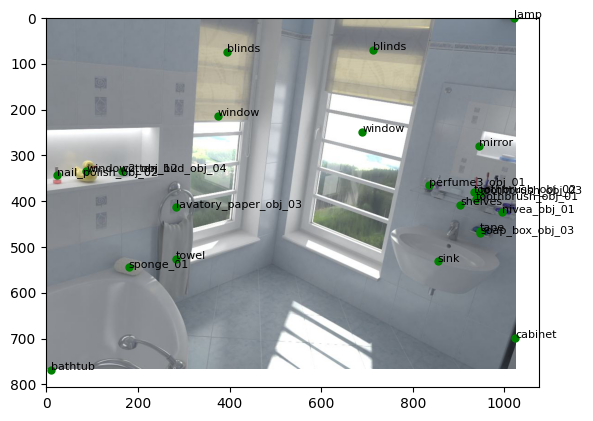

In [14]:
# from mpl_interactions import ioff, panhandler, zoom_factory
# %matplotlib widget

# with plt.ioff():
#     fig, ax = plt.subplots()

# ax.imshow(sample_tonemap_image)
plt.imshow(sample_tonemap_image) ###
x=[]
y=[]
for i in bb_in_sample:
    centre = transform_point_screen_from_world(expand_dims(bb_positions[i], 1))
    xi = np.clip(centre[0].item(), 0, width_pixels)
    yi = np.clip(centre[1].item(), 0, height_pixels)
    x.append(xi)
    y.append(yi)
plt.plot(x, y, "og", markersize=5)
for i, bb in enumerate(bb_in_sample):
    plt.text(x[i], y[i], bb_labels[bb-1], fontsize=8)

# disconnect_zoom = zoom_factory(ax)
# display(fig.canvas)

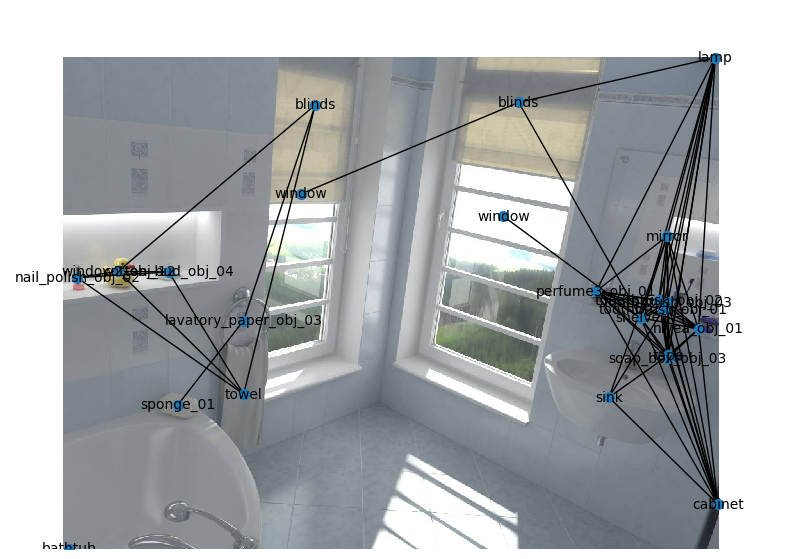

In [15]:
y_lim, x_lim = sample_tonemap_image.shape[:-1]
extent = 0, x_lim, 0, y_lim

fig = plt.figure(figsize=(10,10))
plt.imshow(sample_tonemap_image, extent=extent, interpolation='nearest')
nx.draw(gr, pos=bb_pos, node_size=50, with_labels=True, labels=node_labels_dict, font_size=10)
# plt.show()
plt.savefig("graph_frame_" + str(frame_no))

In [16]:
mesh_objects_si

array([[33],
       [ 1],
       [ 1],
       ...,
       [40],
       [-1],
       [40]], dtype=int64)

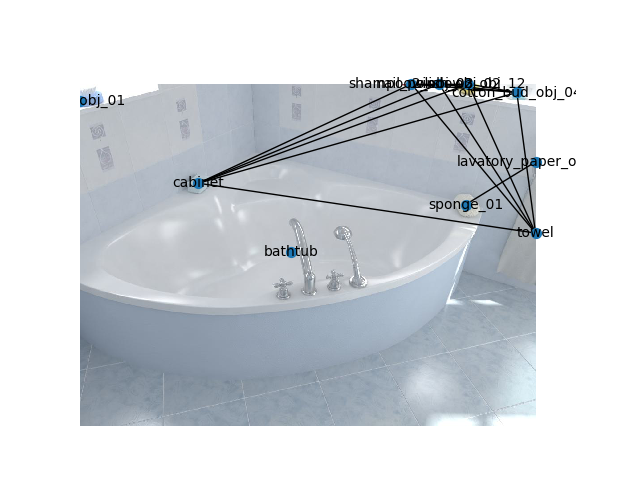

In [118]:
# from mpl_interactions import ioff, panhandler, zoom_factory
# %matplotlib widget

# with plt.ioff():
#     fig, ax = plt.subplots()

# y_lim, x_lim = sample_tonemap_image.shape[:-1]
# extent = 0, x_lim, 0, y_lim

# ax.imshow(sample_tonemap_image, extent=extent, interpolation='nearest')
# nx.draw(gr, pos=bb_pos, node_size=50, with_labels=True, labels=node_labels_dict, font_size=10)

# disconnect_zoom = zoom_factory(ax)
# display(fig.canvas)

loaded  frame.0000.tonemap.jpg and  frame.0000.semantic_instance.hdf5


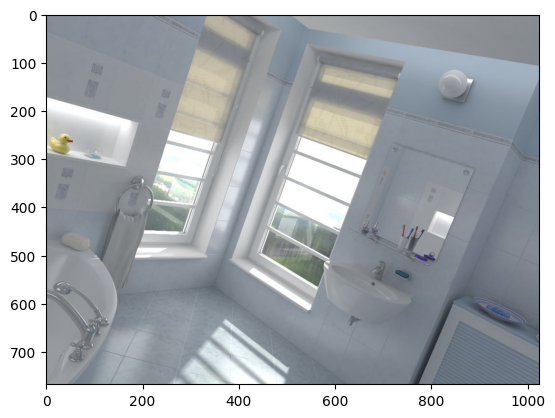

loaded  frame.0001.tonemap.jpg and  frame.0001.semantic_instance.hdf5


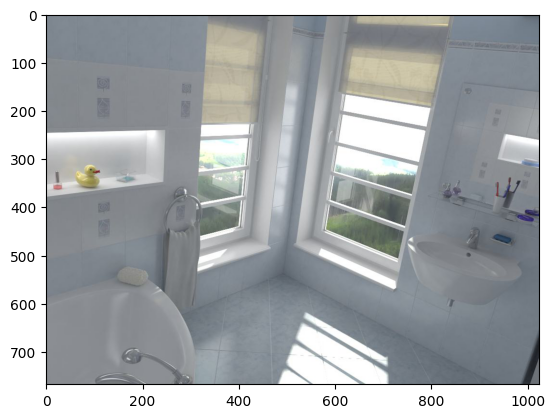

loaded  frame.0002.tonemap.jpg and  frame.0002.semantic_instance.hdf5


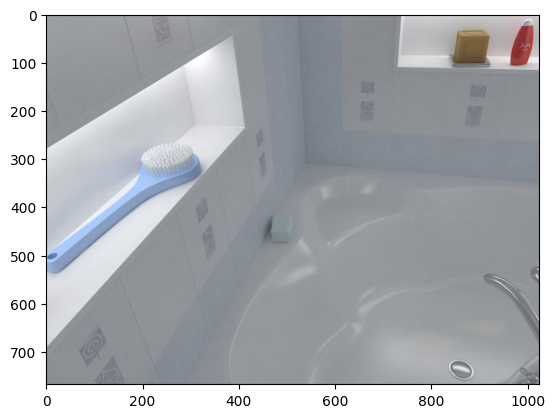

loaded  frame.0003.tonemap.jpg and  frame.0003.semantic_instance.hdf5


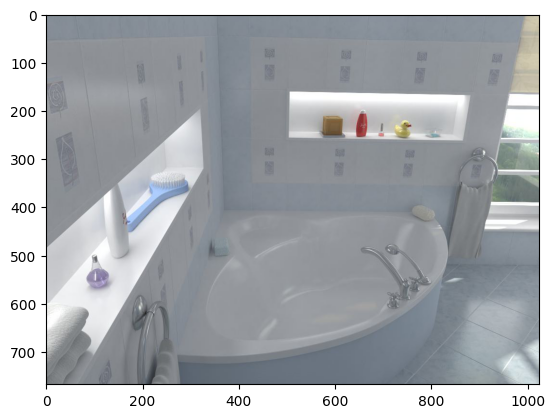

loaded  frame.0004.tonemap.jpg and  frame.0004.semantic_instance.hdf5


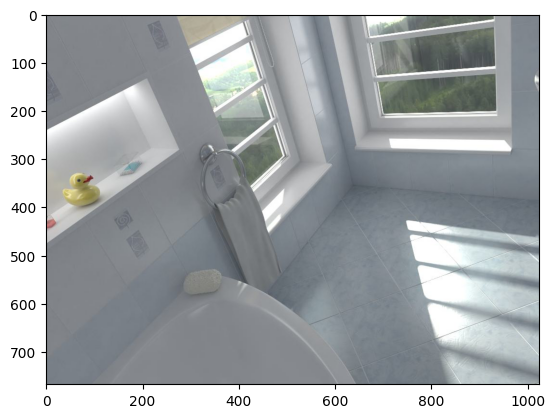

loaded  frame.0005.tonemap.jpg and  frame.0005.semantic_instance.hdf5


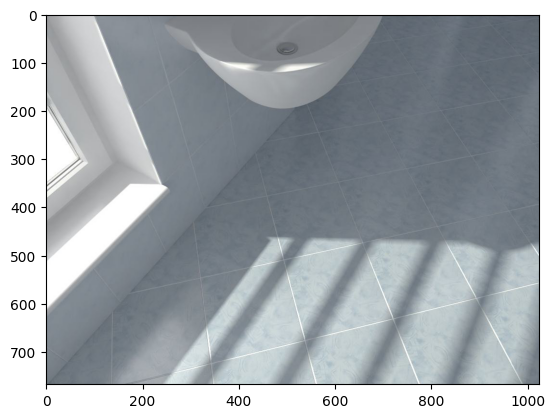

In [43]:
scene_dir = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001"
camera_name = r"cam_00"

images_dir = os.path.join(scene_dir, "images")
preview_files_dir = os.path.join(images_dir, "scene_" + camera_name + "_final_preview")
tonemap_files_dir = os.path.join(images_dir, "scene_" + camera_name + "_final_preview", "frame.*.tonemap.jpg")
geometry_files = os.path.join(images_dir, "scene_" + camera_name + "_geometry_hdf5")
segmentation_files_dir = os.path.join(images_dir, "scene_" + camera_name + "_geometry_hdf5", "frame.*.semantic_instance.hdf5")

filenames_tonemap = [ os.path.basename(f) for f in sort(glob.glob(tonemap_files_dir)) ]
filenames_segmentation = [ os.path.basename(f) for f in sort(glob.glob(segmentation_files_dir)) ]

n_frames = 6
for tonemap_file, segmentation_file, i in zip(filenames_tonemap[:n_frames], filenames_segmentation[:n_frames], arange(n_frames)):
    tonemap_dir = os.path.join(preview_files_dir, tonemap_file)
    segmentation_dir =  os.path.join(geometry_files, segmentation_file)

    tonemap = imread(tonemap_dir)
    with h5py.File(segmentation_dir, "r") as f: segmentation = f['dataset'][:]
    print("loaded ", tonemap_file, "and ", segmentation_file)

    # plt.imshow(tonemap)
    # plt.show()

    